# Deep learning

A deep neural network (multilayer perceptron, MLP) will be used to classify audio recordings as either urban or natural environments. The following plans have been made:

1. I will use the BayesianOptimization hyperparameter tuning procedure to search for the best depth of the model, number of units at each layer, learning rate, and activation function.
2. To avoid overfitting, a dropout layer will be inserted between any two layers, and the dropout rate will also be tuned.
3. Since pre-trained CNN models such as VGGish, YAMNet, and PANNs may represent similar information, I will only use the embeddings of one model at a time, along with features of soundscape indices and the spectrotemporal modulation spectrum.
4. I will train a deep neural network on the features of each of the raw, background (bg), and foreground (fg) signals, as well as on the joint features of these three signals.

In [1]:
import os

from IPython import display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random as python_random

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import regularizers
import pickle

# set the default dpi to 300
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

2023-03-18 13:55:04.551570: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
aggregated_data = pickle.load( open( '../data/processed/20230304/aggregated_data', 'rb' ) )

[train_mps_raw_pca, valid_mps_raw_pca, test_mps_raw_pca,
    train_mps_bg_pca, valid_mps_bg_pca, test_mps_bg_pca,
    train_mps_fg_pca, valid_mps_fg_pca, test_mps_fg_pca,
    train_indices_raw_pca, valid_indices_raw_pca, test_indices_raw_pca,
    train_indices_bg_pca, valid_indices_bg_pca, test_indices_bg_pca,
    train_indices_fg_pca, valid_indices_fg_pca, test_indices_fg_pca,
    train_embedding_raw_pca, valid_embedding_raw_pca, test_embedding_raw_pca,
    train_embedding_bg_pca, valid_embedding_bg_pca, test_embedding_bg_pca,
    train_embedding_fg_pca, valid_embedding_fg_pca, test_embedding_fg_pca,
    train_vgg_raw_pca, valid_vgg_raw_pca, test_vgg_raw_pca,
    train_vgg_bg_pca, valid_vgg_bg_pca, test_vgg_bg_pca,
    train_vgg_fg_pca, valid_vgg_fg_pca, test_vgg_fg_pca,
    train_panns_clip_raw_pca, valid_panns_clip_raw_pca, test_panns_clip_raw_pca,
    train_panns_clip_bg_pca, valid_panns_clip_bg_pca, test_panns_clip_bg_pca,
    train_panns_clip_fg_pca, valid_panns_clip_fg_pca, test_panns_clip_fg_pca,
    train_panns_embedding_raw_pca, valid_panns_embedding_raw_pca, test_panns_embedding_raw_pca,
    train_panns_embedding_bg_pca, valid_panns_embedding_bg_pca, test_panns_embedding_bg_pca,
    train_panns_embedding_fg_pca, valid_panns_embedding_fg_pca, test_panns_embedding_fg_pca,
    y_train, y_valid, y_test] = aggregated_data

# Tensorflow parameter tuning

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [4]:
def build_model_AUC_narrow(hp):

    model = keras.Sequential()
    model.add(layers.Input(shape=(train_data_raw.shape[1]), dtype=tf.float32))
    drop_rate = hp.Float("dr", min_value=0.0, max_value=0.5, sampling="linear")
#         if hp.Boolean("dropout"):
    model.add(layers.Dropout(rate=drop_rate))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=256, step=16),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.Dropout(rate=drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#         loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.AUC(name='AUC')],
    )

    return model

def build_model_AUC_wide(hp):

    model = keras.Sequential()
    model.add(layers.Input(shape=(train_data_all.shape[1]), dtype=tf.float32))
    drop_rate = hp.Float("dr", min_value=0.0, max_value=0.5, sampling="linear")
#         if hp.Boolean("dropout"):
    model.add(layers.Dropout(rate=drop_rate))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=512, step=16),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.Dropout(rate=drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.AUC(name='AUC')],
    )

    return model

In [5]:
def build_model_bACC_narrow(hp):

    model = keras.Sequential()
    model.add(layers.Input(shape=(train_data_raw.shape[1]), dtype=tf.float32))
    drop_rate = hp.Float("dr", min_value=0.0, max_value=0.5, sampling="linear")
    model.add(layers.Dropout(rate=drop_rate))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=256, step=16),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.Dropout(rate=drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    threshold = hp.Float("threshold", min_value=0.3, max_value=0.7, sampling="linear")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=threshold)],
    )

    return model

def build_model_bACC_wide(hp):

    model = keras.Sequential()
    model.add(layers.Input(shape=(train_data_all.shape[1]), dtype=tf.float32))
    drop_rate = hp.Float("dr", min_value=0.0, max_value=0.5, sampling="linear")
    model.add(layers.Dropout(rate=drop_rate))
    # Tune the number of layers.
    for i in range(hp.Int("num_layers", 1, 5)):
        model.add(
            layers.Dense(
                # Tune number of units separately.
                units=hp.Int(f"units_{i}", min_value=16, max_value=512, step=16),
                activation=hp.Choice("activation", ["relu", "tanh"]),
            )
        )
        model.add(layers.Dropout(rate=drop_rate))
    model.add(layers.Dense(1, activation='sigmoid'))
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    threshold = hp.Float("threshold", min_value=0.3, max_value=0.7, sampling="linear")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', threshold=threshold)],
    )

    return model

In [6]:
# panns

directory = '../model/BinaryCrossentropy_bACC'
feat_name = '0315_pannsEmbedding'
objective = 'val_binary_accuracy'


# including panns embeddings
train_data_raw = np.concatenate((train_mps_raw_pca, train_indices_raw_pca, train_panns_embedding_raw_pca), axis = 1)
valid_data_raw = np.concatenate((valid_mps_raw_pca, valid_indices_raw_pca, valid_panns_embedding_raw_pca), axis = 1)
test_data_raw = np.concatenate((test_mps_raw_pca, test_indices_raw_pca, test_panns_embedding_raw_pca), axis = 1)

train_data_bg = np.concatenate((train_mps_bg_pca, train_indices_bg_pca, train_panns_embedding_bg_pca), axis = 1)
valid_data_bg = np.concatenate((valid_mps_bg_pca, valid_indices_bg_pca, valid_panns_embedding_bg_pca), axis = 1)
test_data_bg = np.concatenate((test_mps_bg_pca, test_indices_bg_pca, test_panns_embedding_bg_pca), axis = 1)

train_data_fg = np.concatenate((train_mps_fg_pca, train_indices_fg_pca, train_panns_embedding_fg_pca), axis = 1)
valid_data_fg = np.concatenate((valid_mps_fg_pca, valid_indices_fg_pca, valid_panns_embedding_fg_pca), axis = 1)
test_data_fg = np.concatenate((test_mps_fg_pca, test_indices_fg_pca, test_panns_embedding_fg_pca), axis = 1)

train_data_all = np.concatenate((train_data_raw, train_data_bg, train_data_fg), axis = 1)
valid_data_all = np.concatenate((valid_data_raw, valid_data_bg, valid_data_fg), axis = 1)
test_data_all = np.concatenate((test_data_raw, test_data_bg, test_data_fg), axis = 1)


tuner_raw = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+feat_name)

tuner_bg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+feat_name)

tuner_fg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+feat_name)

tuner_all = kt.BayesianOptimization(build_model_bACC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+feat_name)


tuner_all.search(train_data_all, y_train, epochs=50, validation_data=(valid_data_all, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_bg.search(train_data_bg, y_train, epochs=50, validation_data=(valid_data_bg, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_raw.search(train_data_raw, y_train, epochs=50, validation_data=(valid_data_raw, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_fg.search(train_data_fg, y_train, epochs=50, validation_data=(valid_data_fg, y_valid), callbacks=[stop_early], use_multiprocessing=True)

INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_raw_0315_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_bg_0315_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_fg_0315_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_all_0315_pannsEmbedding/tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


In [7]:
# YAMNet

directory = '../model/BinaryCrossentropy_bACC'
feat_name = '0315_YAMNetEmbedding'
objective = 'val_binary_accuracy'


# YAMNet
train_data_raw = np.concatenate((train_mps_raw_pca, train_indices_raw_pca, train_embedding_raw_pca, train_vgg_raw_pca), axis = 1)
valid_data_raw = np.concatenate((valid_mps_raw_pca, valid_indices_raw_pca, valid_embedding_raw_pca, valid_vgg_raw_pca), axis = 1)
test_data_raw = np.concatenate((test_mps_raw_pca, test_indices_raw_pca, test_embedding_raw_pca, test_vgg_raw_pca), axis = 1)

train_data_bg = np.concatenate((train_mps_bg_pca, train_indices_bg_pca, train_embedding_bg_pca, train_vgg_bg_pca), axis = 1)
valid_data_bg = np.concatenate((valid_mps_bg_pca, valid_indices_bg_pca, valid_embedding_bg_pca, valid_vgg_bg_pca), axis = 1)
test_data_bg = np.concatenate((test_mps_bg_pca, test_indices_bg_pca, test_embedding_bg_pca, test_vgg_bg_pca), axis = 1)

train_data_fg = np.concatenate((train_mps_fg_pca, train_indices_fg_pca, train_embedding_fg_pca, train_vgg_fg_pca), axis = 1)
valid_data_fg = np.concatenate((valid_mps_fg_pca, valid_indices_fg_pca, valid_embedding_fg_pca, valid_vgg_fg_pca), axis = 1)
test_data_fg = np.concatenate((test_mps_fg_pca, test_indices_fg_pca, test_embedding_fg_pca, test_vgg_fg_pca), axis = 1)

train_data_all = np.concatenate((train_data_raw, train_data_bg, train_data_fg), axis = 1)
valid_data_all = np.concatenate((valid_data_raw, valid_data_bg, valid_data_fg), axis = 1)
test_data_all = np.concatenate((test_data_raw, test_data_bg, test_data_fg), axis = 1)


tuner_raw = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+feat_name)

tuner_bg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+feat_name)

tuner_fg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+feat_name)

tuner_all = kt.BayesianOptimization(build_model_bACC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+feat_name)

tuner_all.search(train_data_all, y_train, epochs=50, validation_data=(valid_data_all, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_bg.search(train_data_bg, y_train, epochs=50, validation_data=(valid_data_bg, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_raw.search(train_data_raw, y_train, epochs=50, validation_data=(valid_data_raw, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_fg.search(train_data_fg, y_train, epochs=50, validation_data=(valid_data_fg, y_valid), callbacks=[stop_early], use_multiprocessing=True)

INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_raw_0315_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_bg_0315_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_fg_0315_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_all_0315_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


In [8]:
# VGG

directory = '../model/BinaryCrossentropy_bACC'
feat_name = '0315_vggEmbedding'
objective = 'val_binary_accuracy'


# VGG
train_data_raw = np.concatenate((train_mps_raw_pca, train_indices_raw_pca, train_vgg_raw_pca), axis = 1)
valid_data_raw = np.concatenate((valid_mps_raw_pca, valid_indices_raw_pca, valid_vgg_raw_pca), axis = 1)
test_data_raw = np.concatenate((test_mps_raw_pca, test_indices_raw_pca, test_vgg_raw_pca), axis = 1)

train_data_bg = np.concatenate((train_mps_bg_pca, train_indices_bg_pca, train_vgg_bg_pca), axis = 1)
valid_data_bg = np.concatenate((valid_mps_bg_pca, valid_indices_bg_pca, valid_vgg_bg_pca), axis = 1)
test_data_bg = np.concatenate((test_mps_bg_pca, test_indices_bg_pca, test_vgg_bg_pca), axis = 1)

train_data_fg = np.concatenate((train_mps_fg_pca, train_indices_fg_pca, train_vgg_fg_pca), axis = 1)
valid_data_fg = np.concatenate((valid_mps_fg_pca, valid_indices_fg_pca, valid_vgg_fg_pca), axis = 1)
test_data_fg = np.concatenate((test_mps_fg_pca, test_indices_fg_pca, test_vgg_fg_pca), axis = 1)

train_data_all = np.concatenate((train_data_raw, train_data_bg, train_data_fg), axis = 1)
valid_data_all = np.concatenate((valid_data_raw, valid_data_bg, valid_data_fg), axis = 1)
test_data_all = np.concatenate((test_data_raw, test_data_bg, test_data_fg), axis = 1)


tuner_raw = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+feat_name)

tuner_bg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+feat_name)

tuner_fg = kt.BayesianOptimization(build_model_bACC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+feat_name)

tuner_all = kt.BayesianOptimization(build_model_bACC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+feat_name)

tuner_all.search(train_data_all, y_train, epochs=50, validation_data=(valid_data_all, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_bg.search(train_data_bg, y_train, epochs=50, validation_data=(valid_data_bg, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_raw.search(train_data_raw, y_train, epochs=50, validation_data=(valid_data_raw, y_valid), callbacks=[stop_early], use_multiprocessing=True)
tuner_fg.search(train_data_fg, y_train, epochs=50, validation_data=(valid_data_fg, y_valid), callbacks=[stop_early], use_multiprocessing=True)

INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_raw_0315_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_bg_0315_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_fg_0315_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_bACC/kt_Bayesian_all_0315_vggEmbedding/tuner0.json
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit
INFO:tensorflow:Oracle triggered exit


# Load models

In [9]:
# all

directory = '../model/BinaryCrossentropy_valAUC'
objective = 'val_AUC'
date = '0314'

tuner_YAMNet_all = kt.BayesianOptimization(build_model_AUC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+date+'_YAMNetEmbedding')

tuner_VGG_all = kt.BayesianOptimization(build_model_AUC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+date+'_vggEmbedding')

tuner_panns_all = kt.BayesianOptimization(build_model_AUC_wide,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_all_'+date+'_pannsEmbedding')

# raw
tuner_YAMNet_raw = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+date+'_YAMNetEmbedding')

tuner_VGG_raw = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+date+'_vggEmbedding')

tuner_panns_raw = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_raw_'+date+'_pannsEmbedding')


# bg
tuner_YAMNet_bg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+date+'_YAMNetEmbedding')

tuner_VGG_bg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+date+'_vggEmbedding')

tuner_panns_bg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_bg_'+date+'_pannsEmbedding')


# fg
tuner_YAMNet_fg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+date+'_YAMNetEmbedding')

tuner_VGG_fg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+date+'_vggEmbedding')

tuner_panns_fg = kt.BayesianOptimization(build_model_AUC_narrow,
                     objective=objective,
                     max_trials=100,
                     num_initial_points=25,
                     seed=23,
                     directory=directory,
                     project_name='kt_Bayesian_fg_'+date+'_pannsEmbedding')

INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_YAMNetEmbedding/tuner0.json


2023-03-18 13:55:09.076783: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_pannsEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_fg_0314_YAMNetEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_fg_0314_vggEmbedding/tuner0.json
INFO:tensorflow:Reloading Tuner from ../model/BinaryCrossentropy_valAUC/kt_Bayesian_fg_0314_pannsEmbedding/tuner0.json


In [10]:
tuner_YAMNet_all.results_summary(1)
print('--------------------------------------------------')
tuner_VGG_all.results_summary(1)
print('--------------------------------------------------')
tuner_panns_all.results_summary(1)

Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_YAMNetEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.5
num_layers: 1
units_0: 16
activation: tanh
lr: 0.0001
units_1: 512
units_2: 512
units_3: 448
units_4: 512
Score: 0.792080283164978
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_vggEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.5
num_layers: 1
units_0: 512
activation: relu
lr: 0.0001
units_1: 512
units_2: 512
units_3: 112
units_4: 512
Score: 0.7862818241119385
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_all_0314_pannsEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.3708344678072866
num_layers: 4
units_0: 480
activation: relu
lr: 0.00014023399602325874
units_1: 144
units_2: 448
units_3: 240
Score: 0.7980964779853821


In [11]:
tuner_YAMNet_raw.results_summary(1)
print('--------------------------------------------------')
tuner_VGG_raw.results_summary(1)
print('--------------------------------------------------')
tuner_panns_raw.results_summary(1)

Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_YAMNetEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.5
num_layers: 1
units_0: 208
activation: tanh
lr: 0.0001
units_1: 32
units_2: 256
units_3: 256
units_4: 256
Score: 0.792046070098877
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_vggEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.3153756058853852
num_layers: 1
units_0: 224
activation: relu
lr: 0.0001793417336072447
units_1: 128
units_2: 64
units_3: 256
units_4: 80
Score: 0.790640115737915
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_raw_0314_pannsEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.5
num_layers: 1
units_0: 240
activation: relu
lr: 0.0001
units_1: 128
units_2: 16
units_3: 144
units_4: 16
Score: 0.8059003353118896


In [12]:
tuner_YAMNet_bg.results_summary(1)
print('--------------------------------------------------')
tuner_VGG_bg.results_summary(1)
print('--------------------------------------------------')
tuner_panns_bg.results_summary(1)

Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_YAMNetEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.3708344678072866
num_layers: 4
units_0: 240
activation: relu
lr: 0.00014023399602325874
units_1: 80
units_2: 224
units_3: 128
Score: 0.7902377843856812
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_vggEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.0
num_layers: 1
units_0: 16
activation: relu
lr: 0.01
units_1: 32
units_2: 16
units_3: 256
units_4: 128
Score: 0.7894934415817261
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_bg_0314_pannsEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.37509061706638847
num_layers: 1
units_0: 160
activation: tanh
lr: 0.00039670825539442226
units_1: 192
units_2: 48
units_3: 256
units_4: 256
Score: 0.

In [13]:
tuner_YAMNet_fg.results_summary(1)
print('--------------------------------------------------')
tuner_VGG_fg.results_summary(1)
print('--------------------------------------------------')
tuner_panns_fg.results_summary(1)

Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_fg_0314_YAMNetEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.48339085979399293
num_layers: 1
units_0: 16
activation: relu
lr: 0.0002609603134449437
units_1: 128
units_2: 208
units_3: 128
units_4: 176
Score: 0.7421988844871521
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_fg_0314_vggEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.27071034394674537
num_layers: 1
units_0: 16
activation: relu
lr: 0.0002868519531845337
units_1: 192
units_2: 80
units_3: 208
units_4: 208
Score: 0.728085458278656
--------------------------------------------------
Results summary
Results in ../model/BinaryCrossentropy_valAUC/kt_Bayesian_fg_0314_pannsEmbedding
Showing 1 best trials
Trial summary
Hyperparameters:
dr: 0.2724259376816388
num_layers: 3
units_0: 112
activation: tanh
lr: 0.0005072938580824256
units_1: 144
uni

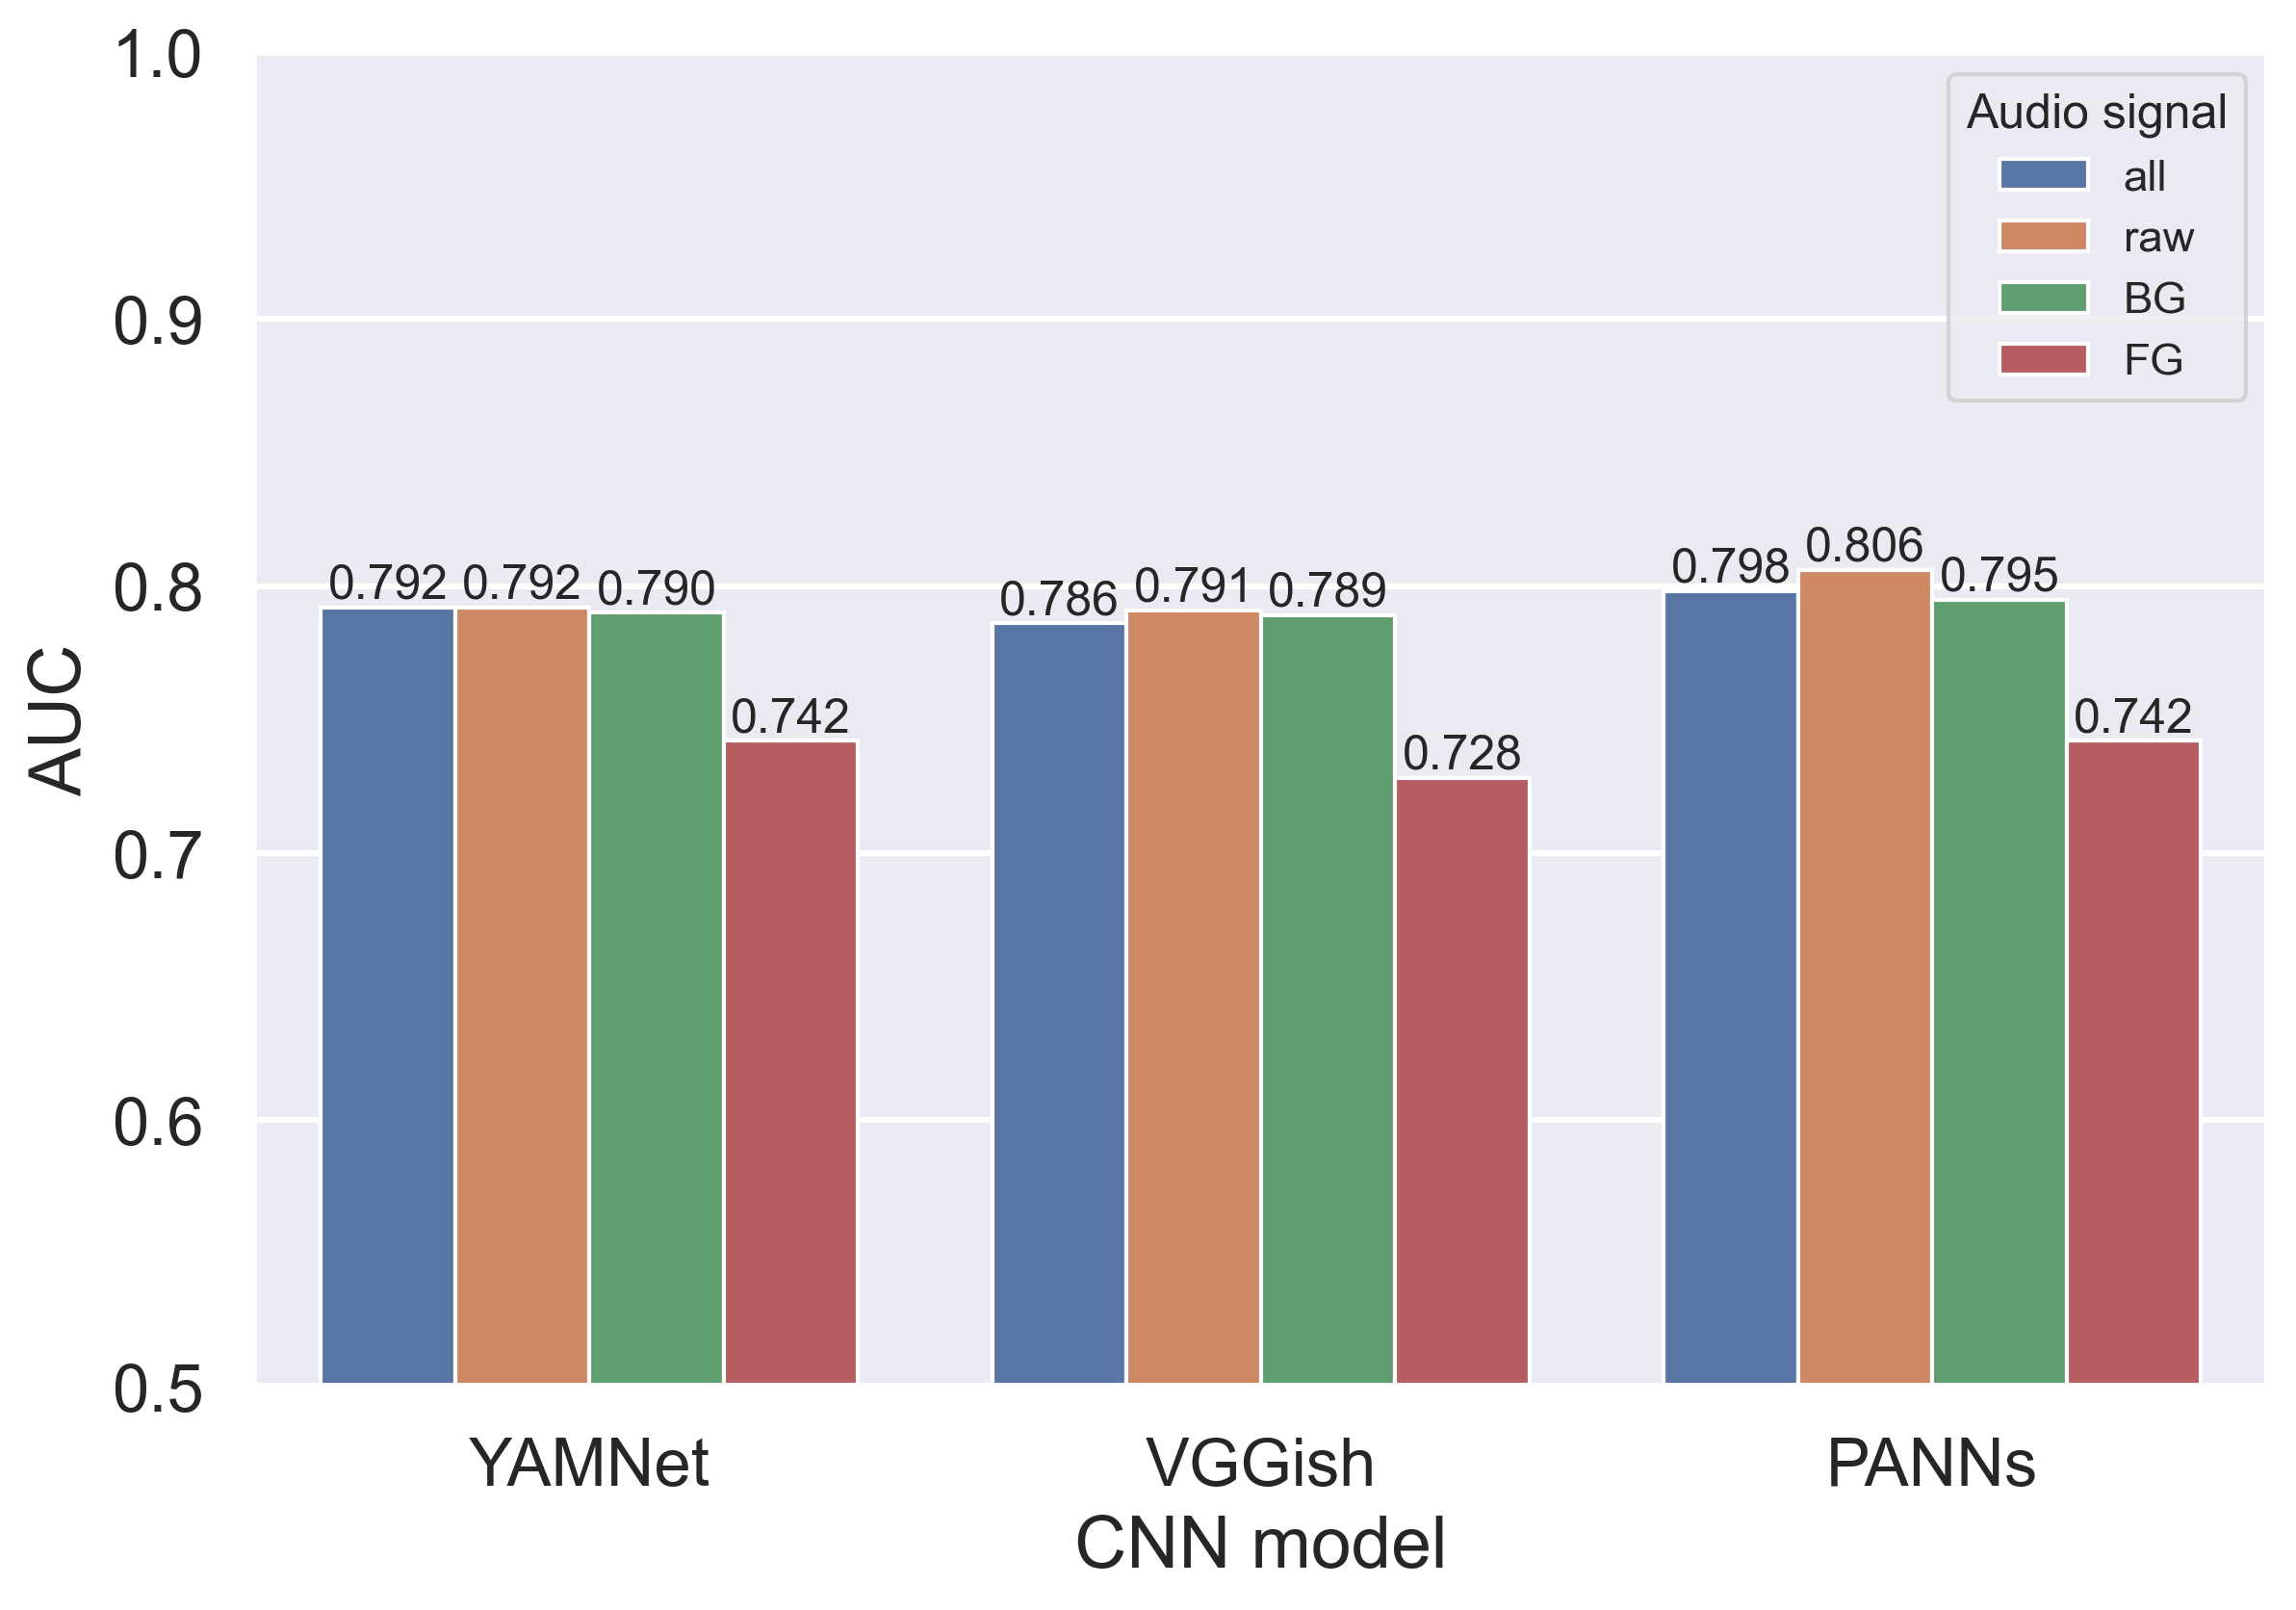

In [14]:
outcome_df = pd.DataFrame({'AUC': [0.792, 0.786, 0.798, 0.792, 0.791, 0.806, 0.790, 0.789, 0.795, 0.742, 0.728, 0.742],
                           'CNN model': ['YAMNet', 'VGGish', 'PANNs',
                                       'YAMNet', 'VGGish', 'PANNs',
                                       'YAMNet', 'VGGish', 'PANNs',
                                       'YAMNet', 'VGGish', 'PANNs'],
                           'Audio signal': ['all','all','all','raw','raw','raw','BG','BG','BG','FG','FG','FG']},
                          index = ['YAMNet_all', 'VGGish_all', 'PANNs_all',
                                   'YAMNet_raw', 'VGGish_raw', 'PANNs_raw',
                                   'YAMNet_bg', 'VGGish_bg', 'PANNs_bg',
                                   'YAMNet_fg', 'VGGish_fg', 'PANNs_fg'])

sns.set_style("darkgrid")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(9,6)) 
sns.set_theme()
sns.barplot(
    data=outcome_df,
    x='CNN model', y='AUC', hue='Audio signal', ax=ax
)
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')
plt.ylim(0.5, 1)
plt.show()


In summary, the deep learning model that combines PANNs embeddings, soundscape indices, and the spectrotemporal modulation spectrum of raw audio signals outperforms the other models.

# Use the best parameters to build a model

In [15]:
# set seed
tf.keras.backend.clear_session()
# tf.random.set_seed(23)
# np.random.seed(23)
# tf.set_random_seed(23)
# python_random.seed(23)

best_hps=tuner_panns_raw.get_best_hyperparameters(num_trials=1)[0]
model = tuner_panns_raw.hypermodel.build(best_hps)
history = model.fit(train_data_raw, y_train, epochs=300, validation_data=(valid_data_raw, y_valid), use_multiprocessing=True)

Epoch 1/300


/Users/andrewchang/opt/anaconda3/envs/AcousticEnv/lib/python3.8/site-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


373/373 [==============================] - 2s 2ms/step - loss: 0.8764 - AUC: 0.5330 - val_loss: 0.6491 - val_AUC: 0.6719
Epoch 2/300
373/373 [==============================] - 1s 2ms/step - loss: 0.7765 - AUC: 0.6014 - val_loss: 0.6149 - val_AUC: 0.7267
Epoch 3/300
373/373 [==============================] - 1s 2ms/step - loss: 0.7473 - AUC: 0.6271 - val_loss: 0.6004 - val_AUC: 0.7453
Epoch 4/300
373/373 [==============================] - 1s 2ms/step - loss: 0.7140 - AUC: 0.6564 - val_loss: 0.5926 - val_AUC: 0.7536
Epoch 5/300
373/373 [==============================] - 1s 2ms/step - loss: 0.7056 - AUC: 0.6590 - val_loss: 0.5881 - val_AUC: 0.7595
Epoch 6/300
373/373 [==============================] - 1s 2ms/step - loss: 0.6950 - AUC: 0.6650 - val_loss: 0.5833 - val_AUC: 0.7657
Epoch 7/300
373/373 [==============================] - 1s 2ms/step - loss: 0.6913 - AUC: 0.6661 - val_loss: 0.5820 - val_AUC: 0.7665
Epoch 8/300
373/373 [==============================] - 1s 2ms/step - loss: 0.6856

373/373 [==============================] - 1s 2ms/step - loss: 0.5886 - AUC: 0.7500 - val_loss: 0.5624 - val_AUC: 0.7869
Epoch 63/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5865 - AUC: 0.7528 - val_loss: 0.5626 - val_AUC: 0.7854
Epoch 64/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5869 - AUC: 0.7541 - val_loss: 0.5618 - val_AUC: 0.7862
Epoch 65/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5875 - AUC: 0.7513 - val_loss: 0.5613 - val_AUC: 0.7863
Epoch 66/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5837 - AUC: 0.7568 - val_loss: 0.5615 - val_AUC: 0.7862
Epoch 67/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5905 - AUC: 0.7511 - val_loss: 0.5624 - val_AUC: 0.7863
Epoch 68/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5819 - AUC: 0.7574 - val_loss: 0.5616 - val_AUC: 0.7864
Epoch 69/300
373/373 [==============================] - 1s 2ms/step - loss:

373/373 [==============================] - 1s 2ms/step - loss: 0.5647 - AUC: 0.7774 - val_loss: 0.5564 - val_AUC: 0.7855
Epoch 124/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5685 - AUC: 0.7747 - val_loss: 0.5567 - val_AUC: 0.7858
Epoch 125/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5676 - AUC: 0.7745 - val_loss: 0.5563 - val_AUC: 0.7858
Epoch 126/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5632 - AUC: 0.7789 - val_loss: 0.5562 - val_AUC: 0.7857
Epoch 127/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5614 - AUC: 0.7776 - val_loss: 0.5551 - val_AUC: 0.7867
Epoch 128/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5655 - AUC: 0.7764 - val_loss: 0.5554 - val_AUC: 0.7863
Epoch 129/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5624 - AUC: 0.7814 - val_loss: 0.5547 - val_AUC: 0.7871
Epoch 130/300
373/373 [==============================] - 1s 2ms/step 

Epoch 184/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5576 - AUC: 0.7851 - val_loss: 0.5551 - val_AUC: 0.7853
Epoch 185/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5605 - AUC: 0.7827 - val_loss: 0.5545 - val_AUC: 0.7859
Epoch 186/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5527 - AUC: 0.7896 - val_loss: 0.5555 - val_AUC: 0.7849
Epoch 187/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5581 - AUC: 0.7839 - val_loss: 0.5558 - val_AUC: 0.7843
Epoch 188/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5549 - AUC: 0.7864 - val_loss: 0.5553 - val_AUC: 0.7854
Epoch 189/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5631 - AUC: 0.7790 - val_loss: 0.5564 - val_AUC: 0.7841
Epoch 190/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5611 - AUC: 0.7823 - val_loss: 0.5561 - val_AUC: 0.7846
Epoch 191/300
373/373 [==============================] 

373/373 [==============================] - 1s 2ms/step - loss: 0.5490 - AUC: 0.7918 - val_loss: 0.5555 - val_AUC: 0.7847
Epoch 245/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5496 - AUC: 0.7919 - val_loss: 0.5550 - val_AUC: 0.7853
Epoch 246/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5534 - AUC: 0.7892 - val_loss: 0.5557 - val_AUC: 0.7854
Epoch 247/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5517 - AUC: 0.7905 - val_loss: 0.5562 - val_AUC: 0.7846
Epoch 248/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5533 - AUC: 0.7895 - val_loss: 0.5564 - val_AUC: 0.7839
Epoch 249/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5496 - AUC: 0.7928 - val_loss: 0.5563 - val_AUC: 0.7843
Epoch 250/300
373/373 [==============================] - 1s 2ms/step - loss: 0.5521 - AUC: 0.7912 - val_loss: 0.5568 - val_AUC: 0.7832
Epoch 251/300
373/373 [==============================] - 1s 2ms/step 

dict_keys(['loss', 'AUC', 'val_loss', 'val_AUC'])


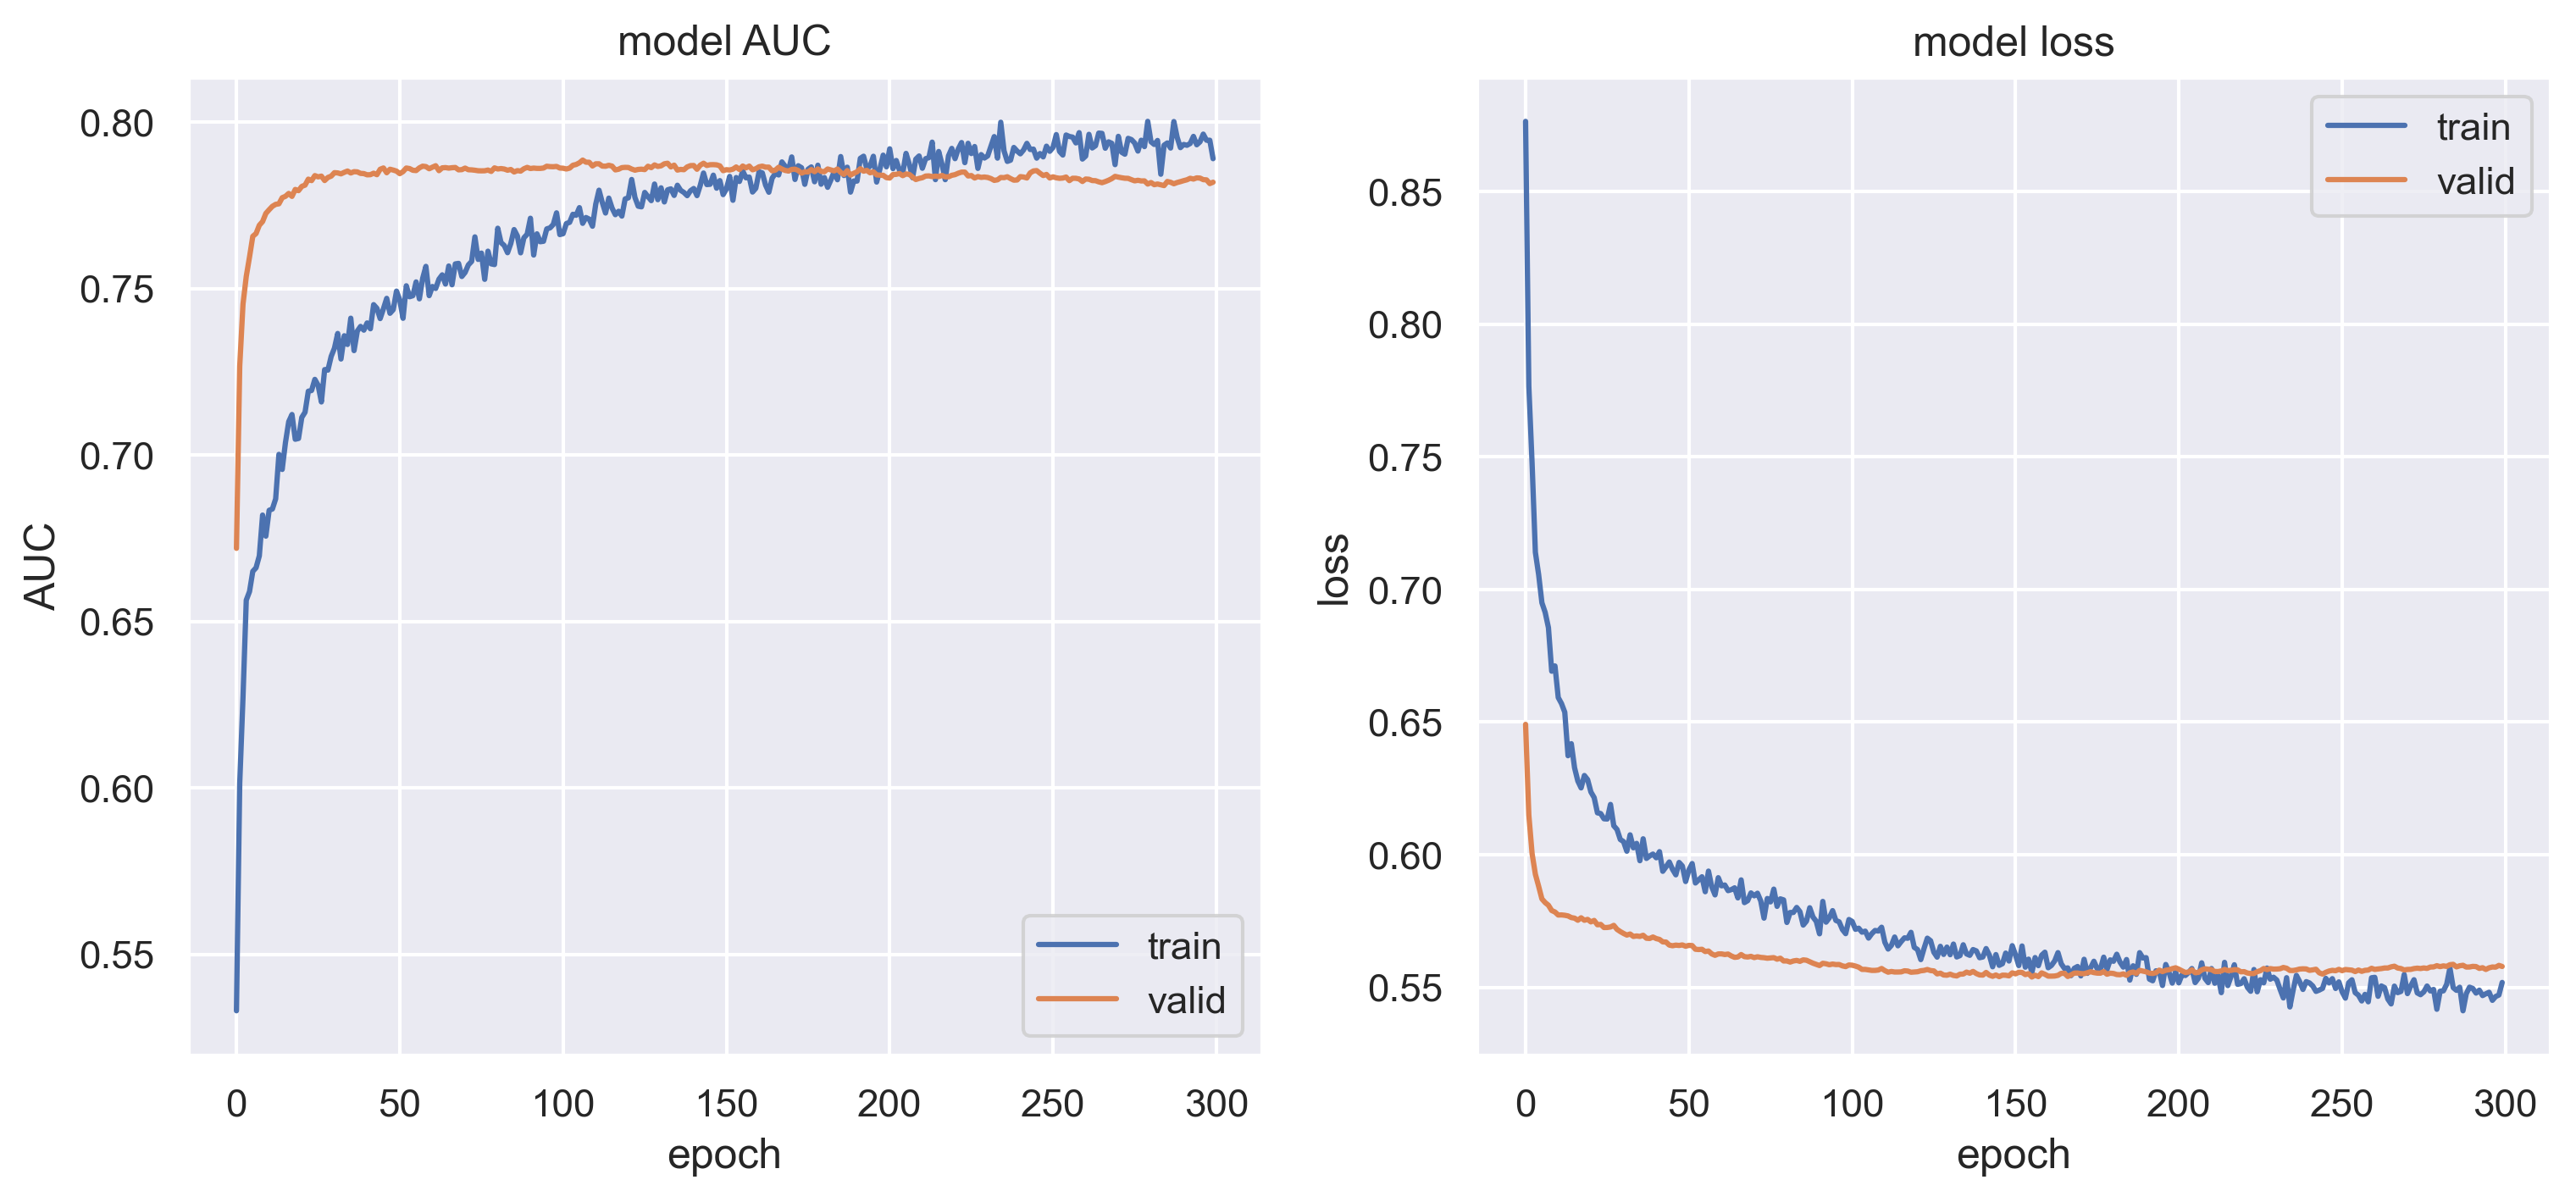

In [16]:
# list all data in history
print(history.history.keys())

fig, (ax1, ax2)  = plt.subplots(ncols=2, figsize=(12,5)) 

# summarize history for accuracy
ax1.plot(history.history['AUC'])
ax1.plot(history.history['val_AUC'])
ax1.title.set_text('model AUC')
ax1.set_ylabel('AUC')
ax1.set_xlabel('epoch')
ax1.legend(['train', 'valid'])
# summarize history for loss
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.title.set_text('model loss')
ax2.set_ylabel('loss')
ax2.set_xlabel('epoch')
ax2.legend(['train', 'valid'])

plt.show()

The model became overfit when the number of epoch reached approximate 180.

In [32]:
val_AUC_per_epoch = history.history['val_AUC']
best_epoch = val_AUC_per_epoch.index(max(val_AUC_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
print('Validation AUC of the best epoch:', str(max(val_AUC_per_epoch)))

Best epoch: 107
Validation AUC of the best epoch: 0.7885770797729492


In [18]:
hypermodel = tuner_panns_raw.hypermodel.build(best_hps)

# set seed
tf.keras.backend.clear_session()
# tf.random.set_seed(23)
# np.random.seed(23)
# tf.set_random_seed(23)
# python_random.seed(23)

import datetime, os
logdir = os.path.join("../model_final/logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

# Retrain the model
hypermodel.fit(train_data_raw, y_train, epochs=best_epoch, validation_data=(valid_data_raw, y_valid), callbacks=[tensorboard_callback], use_multiprocessing=True)

Epoch 1/107
373/373 [==============================] - 2s 2ms/step - loss: 0.8739 - AUC: 0.5329 - val_loss: 0.6483 - val_AUC: 0.6696
Epoch 2/107
373/373 [==============================] - 1s 2ms/step - loss: 0.7915 - AUC: 0.5952 - val_loss: 0.6081 - val_AUC: 0.7329
Epoch 3/107
373/373 [==============================] - 1s 2ms/step - loss: 0.7398 - AUC: 0.6339 - val_loss: 0.5918 - val_AUC: 0.7553
Epoch 4/107
373/373 [==============================] - 1s 2ms/step - loss: 0.7224 - AUC: 0.6457 - val_loss: 0.5817 - val_AUC: 0.7675
Epoch 5/107
373/373 [==============================] - 1s 2ms/step - loss: 0.7045 - AUC: 0.6620 - val_loss: 0.5776 - val_AUC: 0.7722
Epoch 6/107
373/373 [==============================] - 1s 2ms/step - loss: 0.7030 - AUC: 0.6613 - val_loss: 0.5754 - val_AUC: 0.7748
Epoch 7/107
373/373 [==============================] - 1s 2ms/step - loss: 0.6905 - AUC: 0.6704 - val_loss: 0.5744 - val_AUC: 0.7758
Epoch 8/107
373/373 [==============================] - 1s 2ms/step - 

373/373 [==============================] - 1s 2ms/step - loss: 0.5818 - AUC: 0.7587 - val_loss: 0.5615 - val_AUC: 0.7873
Epoch 63/107
373/373 [==============================] - 1s 2ms/step - loss: 0.5819 - AUC: 0.7595 - val_loss: 0.5609 - val_AUC: 0.7872
Epoch 64/107
373/373 [==============================] - 1s 2ms/step - loss: 0.5886 - AUC: 0.7520 - val_loss: 0.5613 - val_AUC: 0.7878
Epoch 65/107
373/373 [==============================] - 1s 2ms/step - loss: 0.5924 - AUC: 0.7470 - val_loss: 0.5614 - val_AUC: 0.7880
Epoch 66/107
373/373 [==============================] - 1s 2ms/step - loss: 0.5817 - AUC: 0.7604 - val_loss: 0.5602 - val_AUC: 0.7888
Epoch 67/107
373/373 [==============================] - 1s 2ms/step - loss: 0.5830 - AUC: 0.7585 - val_loss: 0.5600 - val_AUC: 0.7885
Epoch 68/107
373/373 [==============================] - 1s 2ms/step - loss: 0.5827 - AUC: 0.7564 - val_loss: 0.5596 - val_AUC: 0.7886
Epoch 69/107
373/373 [==============================] - 1s 2ms/step - loss:

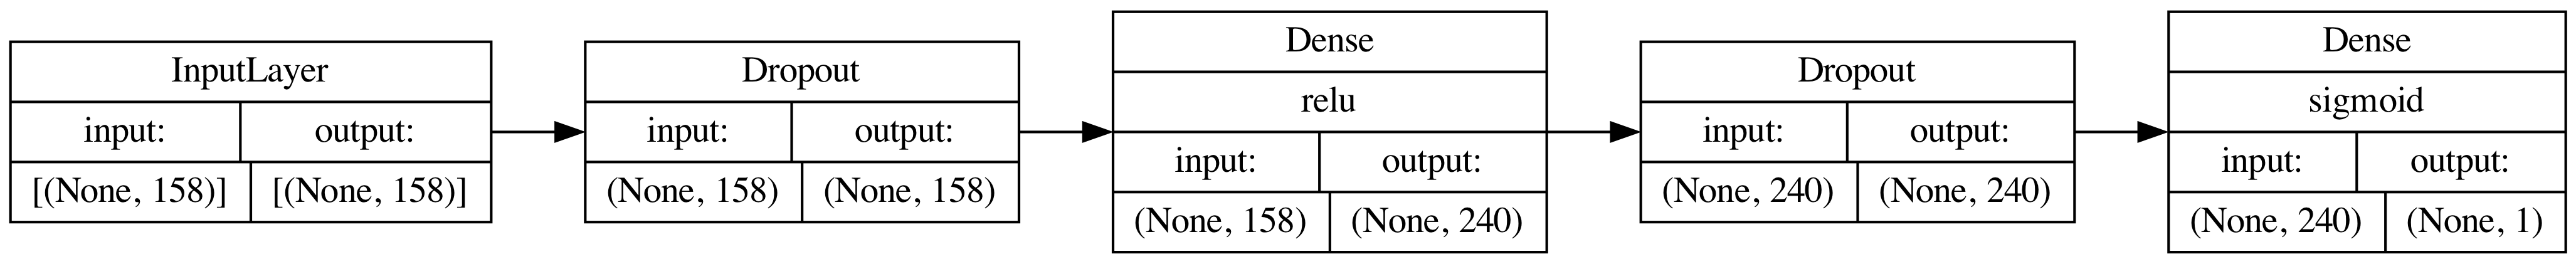

In [20]:
from keras.utils.vis_utils import plot_model
plot_model(hypermodel, show_shapes=True, show_layer_names=False, show_layer_activations=True, rankdir='LR', dpi=300, 
           to_file='../figures/model_panns_raw.png')

In [21]:
%load_ext tensorboard
%tensorboard --logdir ../model_final/logs

In [22]:
hypermodel.save('../model_final/')

INFO:tensorflow:Assets written to: ../model_final/assets


INFO:tensorflow:Assets written to: ../model_final/assets


# Evaluation with testing set

In [23]:
eval_result = hypermodel.evaluate(test_data_raw, y_test)
print("[test loss, test AUC]:", eval_result)

8/8 [==============================] - 0s 2ms/step - loss: 0.5797 - AUC: 0.7631
[test loss, test AUC]: [0.5797374844551086, 0.7630847692489624]


**The test AUC is 0.763, which is only 0.025 lower than the validation AUC. This suggests that the overfitting rate is very low (2.5%) and the model's classification performance is excellent (AUC > 0.75).**

# Plot AUC

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix

8/8 [==============================] - 0s 1ms/step


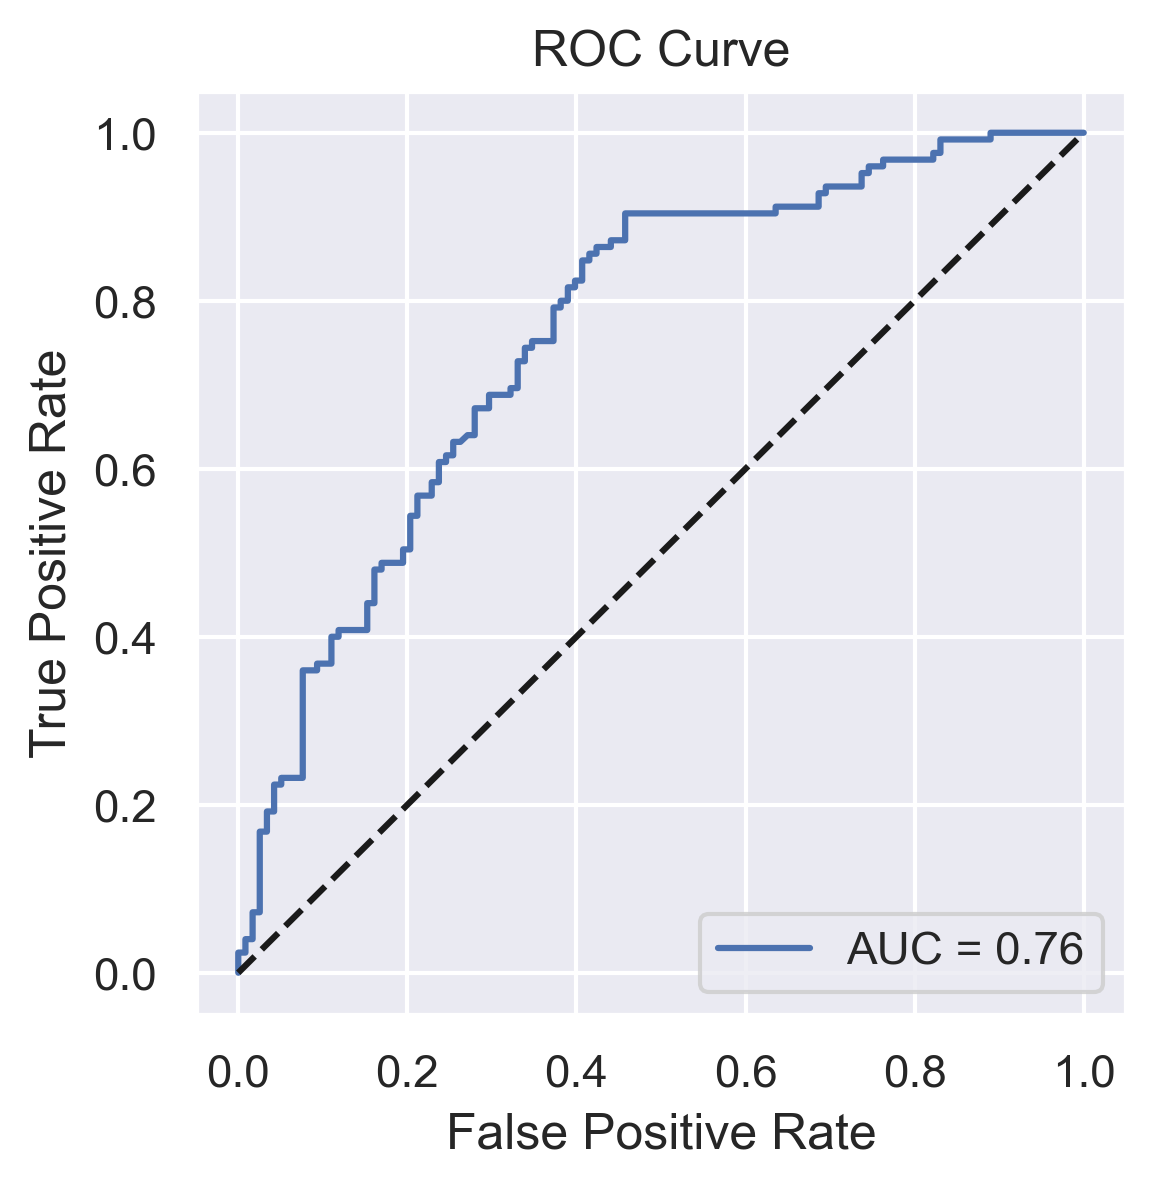

In [25]:
y_pred = hypermodel.predict(test_data_raw).ravel() 
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)

# plot the ROC curve
plt.figure(figsize=(4,4))
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [26]:
max_acc = max((tpr+1-fpr)/2)

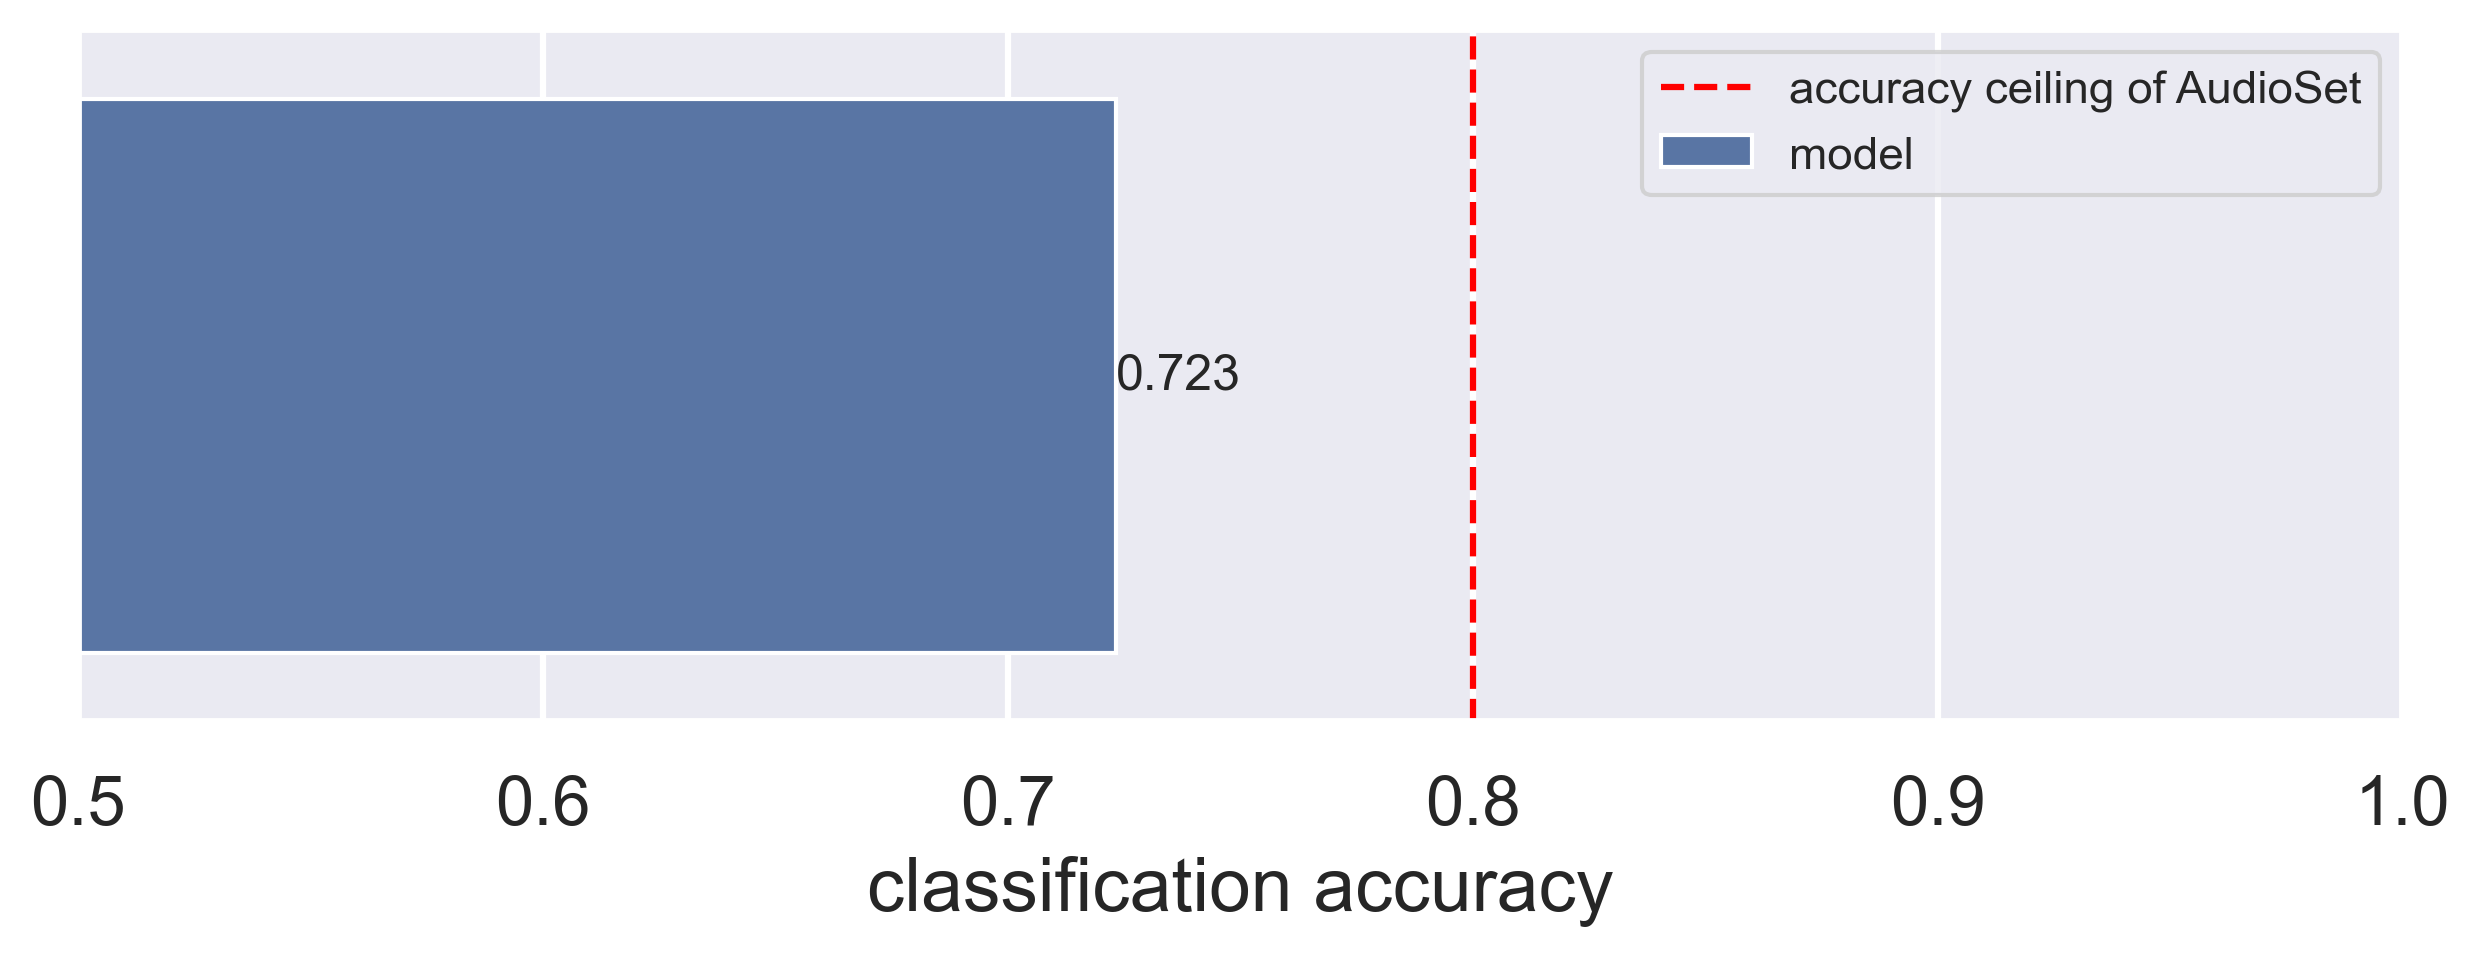

In [27]:
sns.set_style("darkgrid")
sns.set_context("talk")
fig, ax = plt.subplots(figsize=(10,3)) 
sns.set_theme()



sns.barplot(x=[max_acc], y=[0], 
            label='model', color='b', ax=ax, orient='h')
for container in ax.containers:
    ax.bar_label(container, fmt='%.3f')
ax.axvline(x=0.8, color='red', linestyle='--', label='accuracy ceiling of AudioSet')
ax.legend()
plt.xlim(0.5, 1)
ax.set_xlabel("classification accuracy")
ax.set_yticks([])
ax.set_yticklabels([])
plt.show()

# Conclusion
As mentioned in `0-3_re-evaluate_AudioSet_labels.ipynb`, the label accuracy of this dataset is not optimal (only 74/100 randomly sampled audio files were correctly labeled), and the ceiling classification accuracy of the current dataset is assumed to be 80%. Therefore, **the current classification accuracy should be normalized to 0.723/0.8 = 90.3%**, which is excellent.